### Configure
To recreate the plots from the paper (using the [published data](https://doi.org/10.5281/zenodo.7555410), set the data_folder variable below to the path of the unpacked data.zip. If you want to recreat plots from your own data running the experiments, you will have to update the folder paths at the beginning of each section. Also, set ip_target to match that of IP_TARGET in experiments.conf ("10.70.2.2" if using the data from the paper).

For the [TCP RTT Accuracy](#tcp_rtt_accuracy) and [TCP timestamps vs SEQ/ACK no.](#tcp_timestamps_vs_seqack) results you also need to set the pping_path variable to the path of the of the PPing executable from [the build with additional output](https://doi.org/10.5281/zenodo.7589243) on the local machine. If it's been added to PATH it should be sufficient to set it to "pping". To be able to compare the RTTs with those calculated by tshark, the [tshark tool](https://www.wireshark.org/docs/man-pages/tshark.html) must be installed on the local machine.

In [1]:
data_folder = "../data"
ip_target = "10.70.2.2" # Same as IP_TARGET in experiments.conf, the IP of the receiver (M3).
pping_path = "~/src/pping/pping"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import scipy.stats as stats
import sys

# Python scripts used for parsing and plotting result data
import util
import common_plotting as complot
import pping_ping_accuracy_viz as ppa_viz
import pping_tcp_accuracy_viz as pta_viz
import process_data as prodat
import kpping_err_parsing as kp_err
import tcp_rtt_analysis as tra
import pcap_rtt_analysis as pra

In [3]:
def interaction_plot(data, x, hue, y, dodge="auto", capsize="auto", errwidth=2, scale=0.5, **kwargs):    
    n = data[hue].nunique()
    if dodge == "auto":
        dodge = 0.2/n
    if capsize == "auto":
        capsize = 0.1/n
    
    return sns.pointplot(data=data,  x=x, y=y, hue=hue, dodge=dodge, capsize=capsize, 
                         scale=scale, errwidth=errwidth, **kwargs)

def numerize_nflows(df, inplace=True):
    if not inplace:
        df = df.copy()
    
    n_flows = [int(nflows.split("_")[0]) for nflows in df["n_flows"]]
    df["n_flows"] = n_flows
    return df

def numerize_run(df, inplace=True):
    if not inplace:
        df = df.copy()
    
    run_ids = [int(run_id.split("_")[1]) for run_id in df["run"]]
    df["run"] = run_ids
    return df

def load_data(root_folder, convert_to_gbps=True, groupby=["pping_setup", "n_flows", "run"], group_size=None):
    """
    Loads the data and formats it a bit.
    - The n_flows and run columns are numerized (converted from strings to ints)
    - Throughputs are convereted from bps to Gbps
    - A 'network_pps' column is added containing the total packets processed (tx + rx)
    - The relative order of "groups" is normalized (due to how data merging code dynamically loops through subfolders, group order may not be consistent between data sets)
    - Keeps the size of groups consistent (tests sometimes run a bit longer than specified, causing varying numbers of datapoints per experiment)
    
    """
    df = pd.read_csv(os.path.join(root_folder, "data.csv.xz"))
    df = numerize_nflows(df)
    df = numerize_run(df)
    
    if convert_to_gbps:
        for col in ("network_txbps", "network_rxbps", "tcp_throughput"):
            df[col] = df[col] / 1e9
    
    df["network_pps"] = df["network_txpps"] + df["network_rxpps"]
    df["network_Mpps"] = df["network_pps"] / 1e6
    
    df_keep = list()
    gb = df.groupby(groupby)
    if group_size is None:
        group_size = gb.size().min()
    
    for group, group_df in gb:
        df_keep.append(group_df.iloc[:group_size])
    
    return pd.concat(df_keep, ignore_index=True)

<a id="tcp_rtt_accuracy"></a>
## TCP RTT accuracy

In [4]:
%%time
tcp_rtt_folder = os.path.join(data_folder, "rtt_accuracy/tcp/2022-10-14T110904")
rtt_data = pta_viz.load_all_rtt_data(os.path.join(tcp_rtt_folder), pping_path=pping_path, 
                                     srcip=ip_target, tools=["tshark", "PPing", "ePPing"])
rtt_data = tra.add_delay_offset(rtt_data)
rtt_data_matched = tra.filter_comparable_rtts(rtt_data)

CPU times: user 5.51 s, sys: 221 ms, total: 5.73 s
Wall time: 44.4 s


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


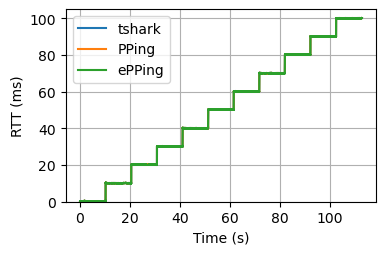

In [5]:
fig, axes = plt.subplots(figsize=(4, 2.5))
complot.plot_pergroup_timeseries(rtt_data, "rtt_ms", print_stats=False, alpha=1.0)
axes.set_ylabel("RTT (ms)")
axes.set_xlabel("Time (s)")
axes.set_ylim(0, 105)

fig.savefig("PAM_TCP_RTT_timeseries.eps", dpi=300, bbox_inches="tight")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


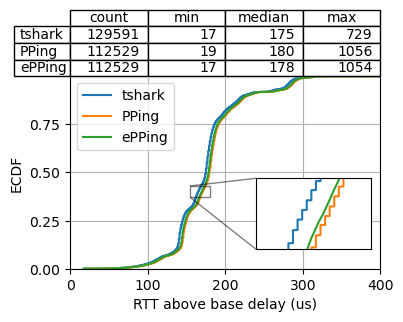

In [6]:
#https://matplotlib.org/stable/gallery/subplots_axes_and_figures/zoom_inset_axes.html

fig, axes = plt.subplots(figsize=(4, 2.5))
complot.plot_pergroup_cdf(rtt_data, "rtt_above_us", axes=axes, print_stats=True, 
                          stat_kwargs={"funcs": ("count", "min", "median", "max"), "fmt":"{:.0f}"}, 
                          alpha=1.0)
axes.set_xlim(0, 400)
axes.set_xlabel("RTT above base delay (us)")
axes.set_ylabel("ECDF")
#axes.set_ylim(0, 1.05)
axes.set_yticks([0, 0.25, 0.5, 0.75])

axins = axes.inset_axes([0.6, 0.1, 0.37, 0.37])
complot.plot_pergroup_cdf(rtt_data, "rtt_above_us", axes=axins, print_stats=False, alpha=1.0)
axins.get_legend().remove()
axins.set_xlim(155, 180)
axins.set_ylim(0.37, 0.43)
axins.grid(False)
#axins.set_xticks([160, 170])
axins.set_xticks([])
axins.set_yticks([])
axins.set_xlabel("")
axins.set_ylabel("")

axes.indicate_inset_zoom(axins, edgecolor="black")

fig.savefig("PAM_TCP_RTTabove_cdf_zoomin.eps", dpi=300, bbox_inches="tight")

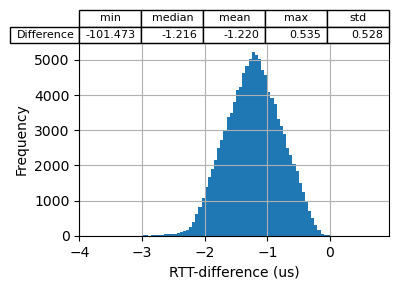

In [7]:
d1 = rtt_data_matched["ePPing"]
d2 = rtt_data_matched["PPing"]
bins = np.arange(-4, 1, 0.05)

fig, axes = plt.subplots(figsize=(4, 2.5))
ppa_viz.plot_rtt_diff(d1, d2, unit="us", axes=axes, stat_kwargs={"fmt": "{:.3f}"}, 
                      density=False, histtype="stepfilled", bins=bins)
axes.set_xlim(bins[0], bins[-1])
axes.get_legend().remove()
fig.savefig("PAM_TCP_RTTdiff_ePPing_PPing.eps", dpi=300, bbox_inches="tight")

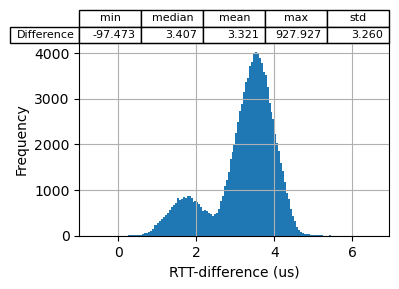

In [8]:
d1 = rtt_data_matched["ePPing"]
d2 = rtt_data_matched["tshark"]

bins = np.arange(-1, 7, 0.05)

fig, axes = plt.subplots(figsize=(4, 2.5))
ppa_viz.plot_rtt_diff(d1, d2, unit="us", axes=axes, stat_kwargs={"fmt": "{:.3f}"}, 
                      density=False, histtype="stepfilled", bins=bins)
axes.set_xlim(bins[0], bins[-1])
axes.get_legend().remove()
fig.savefig("PAM_TCP_RTTdiff_ePPing_tshark.eps", dpi=300, bbox_inches="tight")

## Multicore-performance

In [9]:
multicpu_folder = os.path.join(data_folder, "performance_test/multi_core/2022-10-11T093803")
data_multicpu = load_data(multicpu_folder)

kpping_err_multicpu = kp_err.load_all_kpping_err(multicpu_folder, omit=20)

kpping_err_df_multicpu = prodat.flatten_per_flow_dict(kpping_err_multicpu)
kpping_err_df_multicpu = numerize_nflows(kpping_err_df_multicpu)
kpping_err_df_multicpu = numerize_run(kpping_err_df_multicpu)

In [10]:
data_multicpu["cpu_total_norm"] = data_multicpu["cpu_total"] / 6 # CPU cores on middlebox
df = data_multicpu.query("n_flows == 10")
df_mean = df.groupby(["pping_setup", "run"], as_index=False).mean() # Variation between runs is higher than variation within runs - so treat as 10 idenpendent runs instead of 1000 independent values
order = ["baseline", "PPing", "ePPing"]

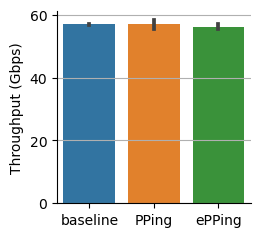

In [11]:
fig, axes = plt.subplots(figsize=(2.5, 2.5))
sns.barplot(data=df_mean, x="pping_setup", y="network_txbps", order=order, axes=axes)

axes.spines["right"].set_visible(False)
axes.spines["top"].set_visible(False)

axes.set_xlabel("")
axes.set_ylabel("Throughput (Gbps)")
axes.grid(axis="y")

fig.savefig("PAM_10flows_allcores_throughput_bar.eps", bbox_inches="tight", dpi=300)

In [12]:
df_mean.groupby("pping_setup")["network_txbps"].mean()

pping_setup
PPing       56.954062
baseline    56.948054
ePPing      56.152551
Name: network_txbps, dtype: float64

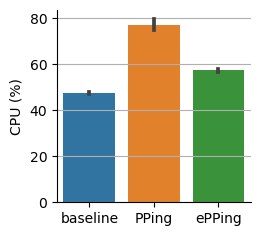

In [13]:
fig, axes = plt.subplots(figsize=(2.5, 2.5))
sns.barplot(data=df_mean, x="pping_setup", y="cpu_total_norm", order=order)

axes.spines["right"].set_visible(False)
axes.spines["top"].set_visible(False)

axes.set_xlabel("")
axes.set_ylabel("CPU (%)")
axes.grid(axis="y")

fig.savefig("PAM_10flows_allcores_cpu_bar.eps", bbox_inches="tight", dpi=300)

In [14]:
df_mean.groupby("pping_setup")["cpu_total_norm"].mean()

pping_setup
PPing       77.13711
baseline    47.38321
ePPing      57.39245
Name: cpu_total_norm, dtype: float64

In [15]:
frac_data = kpping_err_df_multicpu.query("n_flows == 10 and timestamp < 99").copy()
frac_data["fraction"] = (frac_data["processed_packets"].values / 
                         df.query("n_flows == 10 and pping_setup == 'PPing' and timestamp < 99")["network_pps"].values)

frac_data = pd.concat([frac_data, pd.DataFrame({"pping_setup": "ePPing", "run": [1, 2], 
                                                "fraction": [1.0, 1.0]})]) #ePPing never miss packets
frac_data["fraction"] *= 100
frac_data_mean = frac_data.groupby(["pping_setup", "run"], as_index=False).mean()

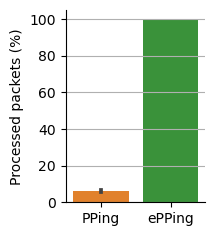

In [16]:
fig, axes = plt.subplots(figsize=(1.8, 2.5))
sns.barplot(data=frac_data_mean, x="pping_setup", y="fraction", order=order[1:], palette=["C1", "C2"])

axes.spines["right"].set_visible(False)
axes.spines["top"].set_visible(False)

axes.set_xlabel("")
axes.set_ylabel("Processed packets (%)")
axes.grid(axis="y")

fig.savefig("PAM_10flows_allcores_fracproc_bar.eps", bbox_inches="tight", dpi=300)

In [17]:
frac_data_mean.groupby("pping_setup")["fraction"].mean()

pping_setup
PPing       6.20687
ePPing    100.00000
Name: fraction, dtype: float64

## Baseline performance

In [18]:
singlecore_folder = os.path.join(data_folder, "performance_test/single_core/2022-10-10T185529")
data = load_data(singlecore_folder)

In [19]:
kpping_err = kp_err.load_all_kpping_err(singlecore_folder, omit=20)
kpping_err_df = prodat.flatten_per_flow_dict(kpping_err)
kpping_err_df = numerize_nflows(kpping_err_df)
kpping_err_df = numerize_run(kpping_err_df)

In [20]:
df1 = data[["n_flows", "pping_setup", "run", "timestamp", "network_pps", "network_Mpps"]].copy()
df1["pping_setup"] = df1["pping_setup"].map({"PPing": "PPing-fw", 
                                             "ePPing": "ePPing", "baseline": 
                                             "baseline"})

df2 = kpping_err_df.copy()
df2["pping_setup"] = "PPing-proc"
df2 = df2.rename(columns={"processed_packets": "network_pps"})
df2["network_Mpps"] = df2["network_pps"] / 1e6

df = pd.concat([df1, df2], ignore_index=True)
df_mean = df.groupby(["pping_setup", "n_flows", "run"], as_index=False).mean()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


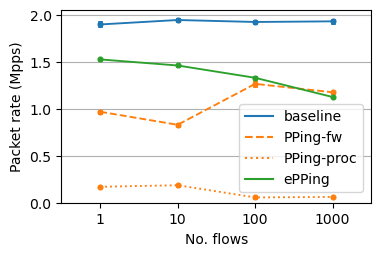

In [21]:
labels = ["baseline", "PPing-fw", "PPing-proc", "ePPing"]
ls = ["-", "--", ":", "-"]
colors = ["C0", "C1", "C1", "C2"]
handles = [axes.plot([], [], c=colors[i], ls=ls[i])[0] for i in range(len(labels))]

fig, axes = plt.subplots(figsize=(4, 2.5))
interaction_plot(df_mean, "n_flows", "pping_setup", "network_Mpps", ax=axes, 
                 hue_order=labels, linestyles=ls, palette=colors, dodge=0)

axes.legend(handles=handles, labels=labels, bbox_to_anchor=[0.995, 0.02], loc="lower right", ncol=1)
axes.set_xlabel("No. flows")
axes.set_ylabel("Packet rate (Mpps)")
axes.grid(axis="y")
axes.set_axisbelow(True) # For some reason the first line (baseline) is drawn behind the gridlines otherwise, regardless of zorder
axes.set_ylim(0, 2.05)
fig.savefig("PAM_performance_overview_packetrate.eps", bbox_inches="tight")

#### Nr reports

(0.0, 131716.963)

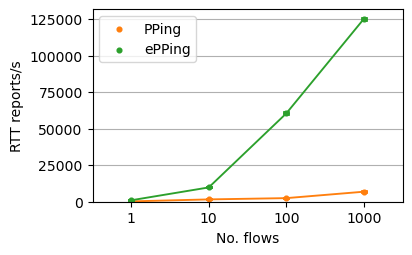

In [22]:
fig, axes = plt.subplots(figsize=(4, 2.5))
d = data.query("pping_setup != 'baseline'").groupby(["pping_setup", "n_flows", "run"], as_index=False).mean()
interaction_plot(d, "n_flows", "pping_setup", "pping_filtered_rtt_events", ax=axes, 
                 hue_order=["PPing", "ePPing"], palette=["C1", "C2"], dodge=0)
axes.legend() # Gets rid of legend title
axes.set_xlabel("No. flows")
axes.set_ylabel("RTT reports/s")
axes.grid(axis="y")
axes.set_axisbelow(True)
axes.set_ylim(0)
#fig.savefig("performance_overview_reports.pdf", bbox_inches="tight")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


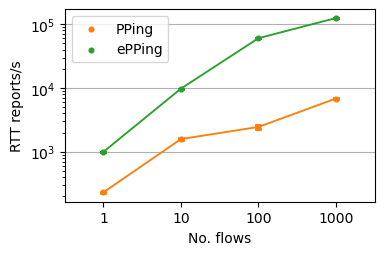

In [23]:
fig, axes = plt.subplots(figsize=(4, 2.5))
interaction_plot(d, "n_flows", "pping_setup", "pping_filtered_rtt_events", ax=axes, 
                 hue_order=["PPing", "ePPing"], palette=["C1", "C2"], dodge=0)
axes.legend() # Gets rid of legend title
axes.set_xlabel("No. flows")
axes.set_ylabel("RTT reports/s")
axes.grid(axis="y")#, which="both")
axes.set_axisbelow(True)
axes.set_yscale("log")
fig.savefig("PAM_report_frequency_log.eps", bbox_inches="tight")

In [24]:
d.groupby(["pping_setup", "n_flows"])["pping_filtered_rtt_events"].mean()

pping_setup  n_flows
PPing        1             232.257
             10           1586.556
             100          2458.024
             1000         6849.346
ePPing       1            1000.003
             10           9785.336
             100         60428.875
             1000       125049.765
Name: pping_filtered_rtt_events, dtype: float64

#### Number of processed packets

In [25]:
pps_table = data.query("pping_setup == 'baseline'").groupby("n_flows")[
    ["network_txpps", "network_rxpps", "network_pps"]].mean()

In [26]:
ff = lambda x: "{:.2f}".format(x)
print((pps_table / 1e6).to_latex(formatters={col: ff for col in pps_table.columns}))

\begin{tabular}{lrrr}
\toprule
{} & network\_txpps & network\_rxpps & network\_pps \\
n\_flows &               &               &             \\
\midrule
1       &          1.86 &          0.04 &        1.90 \\
10      &          1.86 &          0.09 &        1.95 \\
100     &          1.72 &          0.21 &        1.92 \\
1000    &          1.64 &          0.29 &        1.93 \\
\bottomrule
\end{tabular}



### Impact of sampling and aggregation

In [27]:
agg_config_map = {"individual": os.path.join(data_folder, "sampling_rate_impact/individual/2022-10-17T123956"),
                  "aggregated": os.path.join(data_folder, "sampling_rate_impact/aggregated/2022-10-18T201936")}

dfs = list()
for agg, path in agg_config_map.items(): 
    for r in (0, 10, 100, 1000):
        tmp_df = load_data(os.path.join(path, "r_{}".format(r)))
        tmp_df["sample limit (ms)"] = r
        tmp_df["report_mode"] = agg
        dfs.append(tmp_df)

rtest_data = pd.concat(dfs, ignore_index=True)
rtest_data_mean = rtest_data.groupby(["report_mode", "sample limit (ms)", "n_flows", "run"], as_index=False).mean()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


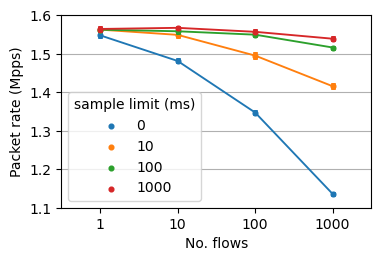

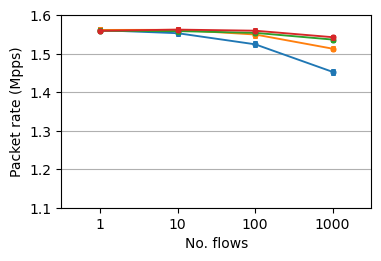

In [28]:
for i, agg in enumerate(["individual", "aggregated"]):
    fig, axes = plt.subplots(figsize=(4, 2.5))
    
    d = rtest_data_mean.query("report_mode == @agg")
    interaction_plot(d, "n_flows", "sample limit (ms)", "network_Mpps", ax=axes, dodge=0)
    axes.set_xlabel("No. flows")
    axes.set_ylabel("Packet rate (Mpps)")
    axes.grid(axis="y")
    axes.set_axisbelow(True) # For some reason the first line (baseline) is drawn behind the gridlines otherwise, regardless of zorder
    axes.set_ylim(1.1, 1.6)
    if (i > 0):
        axes.legend().remove()
    fig.savefig("PAM_r_test_{}.eps".format(agg), bbox_inches="tight")

In [29]:
rtest_data.query("report_mode == 'individual'").groupby(["sample limit (ms)", "n_flows"])["network_pps"].mean()

sample limit (ms)  n_flows
0                  1          1.547766e+06
                   10         1.481198e+06
                   100        1.347177e+06
                   1000       1.135781e+06
10                 1          1.562592e+06
                   10         1.548978e+06
                   100        1.495129e+06
                   1000       1.415567e+06
100                1          1.562454e+06
                   10         1.558305e+06
                   100        1.549477e+06
                   1000       1.516134e+06
1000               1          1.564298e+06
                   10         1.567258e+06
                   100        1.556887e+06
                   1000       1.538977e+06
Name: network_pps, dtype: float64

In [30]:
rtest_data.query("report_mode == 'aggregated'").groupby(["sample limit (ms)", "n_flows"])["network_pps"].mean()

sample limit (ms)  n_flows
0                  1          1.561145e+06
                   10         1.553300e+06
                   100        1.524449e+06
                   1000       1.452821e+06
10                 1          1.561747e+06
                   10         1.562042e+06
                   100        1.549921e+06
                   1000       1.513076e+06
100                1          1.559455e+06
                   10         1.558755e+06
                   100        1.554222e+06
                   1000       1.536773e+06
1000               1          1.559478e+06
                   10         1.562633e+06
                   100        1.559820e+06
                   1000       1.542927e+06
Name: network_pps, dtype: float64

<a id="tcp_timestamps_vs_seqack"></a>
### TCP timestamp vs seq/ack no. differences
For this analysis we actually use PPing (and not ePPing) due to PPing being able to run on packet traces. That way we can ensure all differences are due to the different algorithms (matching TSval/TSecr vs SEQ/ACK, and ePPing uses same algorithm as PPing), without it being affected by the minor difference in clocks between tcpdump and ePPing (already analyzed in the RTT accuracy section). 

In [3]:
%%time
tcp_ex_folder = os.path.join(data_folder, "rtt_error_analysis/2022-10-28T101527")
tool_rtts = pta_viz.load_all_rtt_data(tcp_ex_folder, pping_path=pping_path, srcip=ip_target, 
                                      tools=["tshark", "PPing", "ePPing"])

CPU times: user 274 ms, sys: 59 ms, total: 333 ms
Wall time: 31.8 s


In [4]:
%%time
pcap_rtts = pra.calculate_rtts_from_pcap(pta_viz.get_pcap_file(tcp_ex_folder))

pcap_rtts = pta_viz._filter_and_format_data(pcap_rtts)
ref = pcap_rtts["time"].min() - np.timedelta64(int(tool_rtts["tshark"]["timestamp"].min() * 1e9), "ns")
pcap_rtts["timestamp"] = util.normalize_timestamps(pcap_rtts["time"], ref)
pcap_rtts["rtt"] = pcap_rtts["max_rtt"] # RTT with delayed ACK component

CPU times: user 5min 29s, sys: 137 ms, total: 5min 29s
Wall time: 5min 29s


In [5]:
tool_rtts["pcap_rtt"] = pcap_rtts
matching_rtts = tra.filter_comparable_rtts(tool_rtts)

In [6]:
print("tshark == minimum rtt for each ACK")
all(matching_rtts["tshark"]["rtt"] == matching_rtts["pcap_rtt"]["min_rtt"])

tshark == minimum rtt for each ACK


True

In [7]:
any(matching_rtts["pcap_rtt"]["retrans"])

False

In [8]:
%%time
unsync_err = pra.find_unsync_tsval_update(pta_viz.get_pcap_file(tcp_ex_folder), verbose=False)
unsync_err_tsecr = [err["TSecr"] for err in unsync_err["errors"]]

retrans_err = pra.find_too_fast_retrans(pta_viz.get_pcap_file(tcp_ex_folder), verbose=False)
retrans_err_tsecr = [err["TSecr"] for err in retrans_err["errors"]] +\
                        [err["TSecr"] for err in retrans_err["weak_errors"]]

CPU times: user 10min 6s, sys: 220 ms, total: 10min 6s
Wall time: 10min 7s


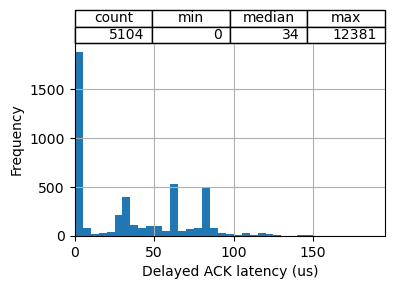

In [9]:
bins = np.arange(0, 200, 5)
fig, axes = plt.subplots(figsize=(4, 2.5))
ppa_viz.plot_rtt_diff(matching_rtts["pcap_rtt"], matching_rtts["tshark"], unit="us", axes=axes, 
                      stat_kwargs={"funcs": ("count", "min", "median", "max"), "fmt":"{:.0f}"}, 
                      density=False, histtype="stepfilled", stats_label="", bins=bins)
axes.get_legend().remove()
axes.set_xlim(bins[0], bins[-1])
axes.set_xlabel("Delayed ACK latency (us)")
fig.savefig("PAM_tcp_rtt_diff_delack_example.eps", bbox_inches="tight", dpi=300)

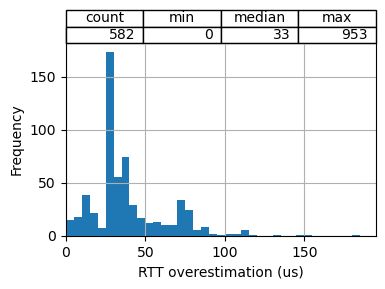

In [10]:
unsync_mask = matching_rtts["PPing"]["tsecr"].isin(unsync_err_tsecr)

bins = np.arange(0, 200, 5)
fig, axes = plt.subplots(figsize=(4, 2.5))
ppa_viz.plot_rtt_diff(matching_rtts["PPing"].loc[unsync_mask], matching_rtts["pcap_rtt"].loc[unsync_mask], unit="us", axes=axes, 
                      stat_kwargs={"funcs": ("count", "min", "median", "max"), "fmt":"{:.0f}"}, 
                      density=False, histtype="stepfilled", stats_label="", bins=bins)
axes.get_legend().remove()
axes.set_xlim(bins[0], bins[-1])
axes.set_xlabel("RTT overestimation (us)")
fig.savefig("PAM_tcp_rtt_diff_edgecase2_example.eps", bbox_inches="tight", dpi=300)